In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

In [482]:
# Definimos la url a scrapear

url = 'https://www.justiciachaco.gov.ar/Despacho/Juan_Jose_Castelli/Familia/Juzgado_Ninez_Adolescencia_Familia_1/'

base_url = "https://www.justiciachaco.gov.ar"

In [483]:
# Realizamos una solicitud GET a la página web
response = requests.get(url)

print(response)

<Response [200]>


In [484]:
# Parseamos el HTML de la página con BeautifulSoup
sopa = BeautifulSoup(response.text, 'html.parser')

In [485]:
# Encontrar todos los enlaces .txt
links = [base_url + link["href"] for link in sopa.find_all("a") if link["href"].endswith(".txt")]

In [486]:
# Creamos una lista que contiene el contenido de cada link

textos = []
for link in links:
    r = requests.get(link)
    soup = BeautifulSoup(r.content, 'html.parser')
    texto = soup.get_text()
    textos.append(texto)

In [489]:
# Guardamos los textos en otra variable por las dudas
listas=textos

In [490]:
# Nos encontramos con el problema de que ahora contenemos todas las listas en una lista de python
# Por lo cual debemos limpiarla. Vamos a empezar extrayendo la fecha y ubicándola en una nueva columna
# Nos va a permitir después eliminar todo el encabezado de las listas de despacho para separar cada expte luego.
# Lo vamos a hacer con expresiones regulares

'''
Este código busca una cadena que comienza con "Fecha Despacho: " y luego tiene una fecha en formato dd/mm/yyyy. 
La expresión regular utilizada aquí, (\b\d{2}/\d{2}/\d{4}\b), coincide con cualquier cadena que tenga dos dígitos, 
una barra, dos dígitos, otra barra y cuatro dígitos.

'''

import re

# Definir un patrón de búsqueda para una fecha en formato DD/MM/AAAA
patron = r'\b\d{1,2}/\d{1,2}/\d{4}\b'

# Buscar todas las fechas en la lista y guardarlas en una lista separada
fechas = re.findall(patron, ''.join(listas))

# Imprimir las fechas encontradas

print(len(fechas))

232


In [494]:
datos = listas[0].split("---------------------------------------------------------------------------------\r\nOrden  Expediente             Caratula\r\n---------------------------------------------------------------------------------\r\n")[1].split("\r\n")




lista_datos = []
for d in datos:
    d = d.strip()
    if len(d) > 0:
        columnas = d.split("  ")
        lista_datos.append(columnas)
        
        
lista_datos[:1]

[['1',
  '',
  ' 1001/14',
  '',
  '',
  '',
  ' A.................... S/ACCION DE AMPARO']]

In [495]:
'''
Ahora podemos observar que se extrayeron gran parte de los datos, pero aún se encuentran algo sucio.
Tenemos el nombre de lxs abogadxs intervinientes y algunos datos vacios. Buenos, vamos a limpiarlos.
Vamos a quedarnos sólamente con los que comiencen con un dato numérico, el cual corresponde a la columna de orden.
'''


# Filtramos la lista para obtener sólo las sublistas que contienen un número de orden
lista_filtrada = list(filter(lambda x: len(x) > 0 and x[0].isdigit(), lista_datos))



# Limpiamos de datos vacíos  y sólamente nos quedamos con las benditas 3 columnas!

for i in range(len(lista_filtrada)):
    lista_filtrada[i] = [dato.strip() for dato in lista_filtrada[i] if dato.strip()]

    
# Mostramos la lista filtrada
lista_filtrada

[['1', '1001/14', 'A.................... S/ACCION DE AMPARO'],
 ['2', '914/18', 'A.................... S/ALIMENTOS'],
 ['3', '280/21-S', 'A.................... S/CONTROL DE LEGALIDAD'],
 ['4', '312/21-S', 'A.................... S/CONTROL DE LEGALIDAD'],
 ['5', '330/21-C', 'A.................... S/MEDIDA CAUTELAR'],
 ['6', '140/19', 'A.................... S/VIOLENCIA FAMILIAR'],
 ['7', '369/20', 'A.................... S/VIOLENCIA FAMILIAR'],
 ['8', '1728/19', 'B.................... S/DIVORCIO'],
 ['9', '1368/16', 'B.................... S/DIVORCIO VINCULAR'],
 ['10', '347/20', 'C.................... S/ELEVA ACTUACIONES'],
 ['11', '647/20', 'C.................... S/ELEVA ACTUACIONES'],
 ['12', '249/21-C', 'C.................... S/HOMOLOGACION DE CONVENIO'],
 ['13', '352/21-S', 'C.................... S/VIOLENCIA DE GENERO'],
 ['14', '364/21-S', 'C.................... S/VIOLENCIA DE GENERO'],
 ['15', '413/20', 'C.................... S/VIOLENCIA FAMILIAR'],
 ['16', '429/19', 'C..............

In [753]:
# Ahora vamos a repetir lo mismo, con toooodas las demás listas tratando de iterar con un ciclo for

# Iterar sobre cada elemento de la lista `listas`

listas_sin_fecha = []

for lista in listas:
    # Aplicar el mismo código a cada elemento
    datos = lista.split("---------------------------------------------------------------------------------\r\nOrden  Expediente             Caratula\r\n---------------------------------------------------------------------------------\r\n")[1].split("\r\n")
    lista_datos = []
    for d in datos:
        d = d.strip()
        if len(d) > 0:
            columnas = d.split("  ")
            lista_datos.append(columnas)
    # Guardamos la lista_datos en a la lista_sin_fecha
    listas_sin_fecha.append(lista_datos)

In [754]:
# Limpiamos y nos quedamos solo con aquellos rows que arrancan con el número de orden

listas_despacho_limpias_sin_fecha = []

# Bucle para iterar sobre cada elemento de la lista
for elemento in listas_sin_fecha:
    lista_filtrada = list(filter(lambda x: len(x) > 0 and x[0].isdigit(), elemento))
    listas_despacho_limpias_sin_fecha.append(lista_filtrada)

In [755]:
# Limpiamos cada lista y dejamos sólamente 3 columnas

for lista in  listas_despacho_limpias_sin_fecha:
    for i in range(len(lista)):
        lista[i] = [dato.strip() for dato in lista[i] if dato.strip()]

In [793]:
'''
Este ciclo for lo que hace es las listas que tenían 4 elementos convinar los últimos dos y que queden todos
de tres elementos por que sino no podía armar los dataframe. Debería ir más arriba junto con códigos después de 
escrapear y limpiar, justo antes del primer dataframe.
'''
#Conbinamos el último string en caso de que haya 4 o más columnas

for sublista in listas_despacho_limpias_sin_fecha:
    for i in sublista:
        if len(i) == 4 and 'INSCRIPCION' in i[2] and 'DE RECONOCIMIENTO' in i[3]:
            i[2] = i[2].replace(' S/.INSCRIPCION', ' DE RECONOCIMIENTO S/.INSCRIPCION')
            i.pop(-2)

In [ ]:
'''
Ciclo for para anexar a cada tabla la fecha del despacho. Ahora tenemos una columna más, actualizamos el df
'''

for i, lista in enumerate(lista_prueba):
    fecha=lista_fechas[i]
    for j in lista:
        j.append(fecha)

In [795]:
# Ahora tengo todas las listas pero están en 12mil listas distintas, vamos a ver su podemos compactar y unirlas
# en 232 listas que es lo que corresponde a nuestras listas de despacho, pero primero vamos a meterlo en un df

import pandas as pd

# Crear el dataframe vacío con las columnas deseadas
df = pd.DataFrame(columns=['Orden', 'Expediente', 'Caratula', 'Fecha'])

# Recorrer la lista de sublistas y agregar cada sublista como una fila en el dataframe
for lista in listas_despacho_limpias_sin_fecha:
    for i in lista:
        df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)

/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Orden': i[0], 'Expediente': i[1], 'Caratula': i[2], 'Fecha': i[3]}, ignore_index=True)
/tmp/ipykernel_124327/738302621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

In [722]:
'''
Vamos a crear tantos dataframe vaciós como listas de despacho tengamos
que se van a llamar de la siguiente manera "df_DD_MM_AAAA", para luego, incorporar a cada dataframe
uno de las sublistas de la lista lista_despachos_sin_fecha"

'''

from datetime import datetime

#Convertimos los string de las fechas en una lista de objetos dateTime

#fechas_str = fechas
#fechas = [datetime.strptime(fecha_str, "%d/%m/%Y") for fecha_str in fechas_str]


# Creamos el diccionario vacio que va a contener todos los dataframe

dataframes = {}

# Iteramos por cada fecha y creamos el dataframe
for fecha in fechas:
    nombre_df = "df_" + fecha.strftime("%d_%m_%Y")
    dataframes[nombre_df] = pd.DataFrame(columns=['Orden', 'Expediente', 'Caratula'])

In [9]:
df.to_csv('despacho_a_22_03_23_prueba.csv')

In [13]:
df = df.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'])
df.columns

Index(['Orden', 'Expediente', 'Caratula', 'Fecha'], dtype='object')

In [23]:

# Extraer la parte del texto después de 'S/' en la columna 'Expediente' y guardarla en una nueva columna 'Proceso'
df['Proceso'] = df['Caratula'].str.extract('S/(.*)', expand=False)

# Imprimir el DataFrame actualizad

df

,Orden,Expediente,Caratula,Fecha,Proceso
0,1,1001/14,A.................... S/ACCION DE AMPARO,17-12-2021,ACCION DE AMPARO
1,2,914/18,A.................... S/ALIMENTOS,17-12-2021,ALIMENTOS
2,3,280/21-S,A.................... S/CONTROL DE LEGALIDAD,17-12-2021,CONTROL DE LEGALIDAD
3,4,312/21-S,A.................... S/CONTROL DE LEGALIDAD,17-12-2021,CONTROL DE LEGALIDAD
4,5,330/21-C,A.................... S/MEDIDA CAUTELAR,17-12-2021,MEDIDA CAUTELAR
...,...,...,...,...,...
12454,41,917/18,S.................... S/GUARDA JUDICIAL,22-03-2023,GUARDA JUDICIAL
12455,42,104/21-C,S.................... S/MEDIDA AUTOSATISFACTIVA,22-03-2023,MEDIDA AUTOSATISFACTIVA
12456,43,432/23,T.................... S/VIOLENCIA DE GÉNERO,22-03-2023,VIOLENCIA DE GÉNERO
12457,44,691/22-S,Z.................... S/PROTECCION INTEGRAL,22-03-2023,PROTECCION INTEGRAL


<AxesSubplot:>

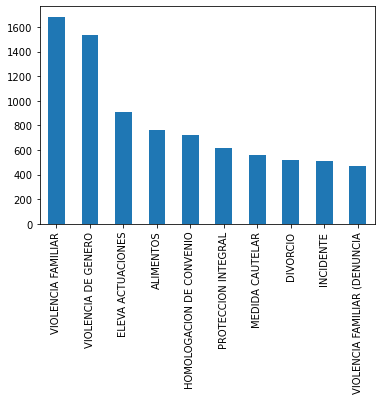

In [32]:
df.Proceso.value_counts().head(10).plot.bar()

In [33]:
df.to_csv('listas_despachos.csv')

232
232
